In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random
from datetime import timedelta  

In [2]:
dpath = {}
dpath['home'] = './data/conflicts'
dpath['subfolder'] = 'input'
dpath['filename'] = '2001-01-01-2019-10-01-Djibouti-Ethiopia-Kenya-Somalia.csv'
dfc = pd.read_csv(os.path.join(dpath['home'],dpath['subfolder'],dpath['filename']))

Choices that I made during preprocessing that need to be confirmed for validity:

1. To generate the heat map we only need lat,lon,fatality and time information. <br>
2. Filter for somalia only, later the data can be augemented with surrounding countries, however the test set should only be somalia. <br>
3. Filted out peacefull protests. Are we trying to predict all the conflict subevents? Or or some types of conflicts more related to droughts / displacements.? Are for example peacefull protests linked to drought? 

Question: Is there also displacement data available for surrounding countring like ethiopia, djibouti, kenya?


In [3]:
# Filtering for somalian cases
dfc = dfc[[i[:3] == 'SOM' for i in dfc['event_id_cnty'].values]]

# Dropping peaceful protests
dfc = dfc.drop(dfc[dfc['sub_event_type'] == 'Peaceful protest'].index)

# Typesetting
dfc['ts'] = pd.to_datetime(dfc['event_date'])
dfc['latitude'] = dfc['latitude'].astype(float)
dfc['longitude'] = dfc['longitude'].astype(float)
dfc['fatalities'] = dfc['fatalities'].astype(int)

dfc = dfc[['ts','latitude','longitude','fatalities']]
dfc.columns = ['ts','lat','lon','fatalities']

# Write to csv
dpath = {}
dpath['home'] = './data/conflicts'
dpath['subfolder'] = 'input'
dpath['filename'] = '2001-01-01-2019-10-01-Somalia-Events-Only.csv'
dfc.to_csv(os.path.join(dpath['home'],dpath['subfolder'],dpath['filename']))

In [4]:
df = dfc

In [5]:
from utils import create_idx_fixed_minmax

In [6]:
# Define the grid which we want to use to divide your map into zones

# map_width = 5
# map_height = 3 # Number of zones that the map will be divided vertically 

map_width = 64
map_height = 64 # 

grid = (map_width,map_height)

# Add a grid position to a dataframe with a 'lat' and a 'lon' column
# Map (lon, lat) into (grid_h, grid_w)
df_indexed = create_idx_fixed_minmax(df, grid)

Min Lat: -2 , Max Lat: 13
Min Lon: 40 , Max Lon: 52
At this configuration a pixel is about 20.73 km by 26.09 km


In [7]:
df_indexed.head()

,ts,lat,lon,fatalities,grid_h,grid_w
1,2019-09-28,1.7131,44.7639,2,38.592533,15.842560
2,2019-09-28,1.9833,44.8333,0,38.222400,16.995413
3,2019-09-28,-0.3603,42.5463,9,50.419733,6.996053
4,2019-09-28,2.4492,45.3542,1,35.444267,18.983253
5,2019-09-28,1.9833,44.8333,10,38.222400,16.995413


In [8]:
############################################################################################
# Create heatmaps
############################################################################################

# Hyperparameters for heatmap construction
T = 1 # Period frequency 1, 2, 3 ,4 
freq = 'W' # Date frequency that can be D, W, M for Days, Weeks, Months and so on

# Aggregate (time, square, category) to create the incident map sum 
df_indexed_count = df_indexed.groupby(['grid_w','grid_h','fatalities', pd.Grouper(key='ts', freq=freq)],as_index=True).size()    
df_indexed_count = df_indexed_count.reset_index()  
df_indexed_count.rename(columns ={0:'CI'},inplace=True)
df_indexed_count['CI'] += df_indexed_count['fatalities']
df_indexed_count = df_indexed_count.sort_values(by=['ts'])

In [9]:
df_indexed_count.head()

,grid_w,grid_h,fatalities,ts,CI
14588,21.833387,44.549867,0,2001-01-07,1
17020,26.114987,43.264533,0,2001-01-07,1
16814,25.677653,39.932267,0,2001-01-07,1
12259,18.560000,35.289067,0,2001-01-07,1
6779,17.243307,35.553600,3,2001-01-14,4


In [10]:
############################################################################################
# Create our data as dictionary for easy access composed of tuples (heatmap, coords) selected by date key
############################################################################################
heat_data = {}

for ts in df_indexed_count.ts.unique():
    
    #print("Processing data: {0}".format(ts))   

    # Select data just for this timestamp
    points_by_date = df_indexed_count[df_indexed_count.ts == ts]
    # Create heatmap
    heatmap = np.zeros(grid)
    
    # Get incident coordinates
    conf_coords = []
    
    # Parse crime incident and heatmap
    for index, row in points_by_date.iterrows():
        conf_coords.append((row['grid_w'],row['grid_h']))
        
        heatmap[int(row['grid_w'])][int(row['grid_h'])] += row['CI']
    
    conf_coords = np.asarray(conf_coords)
    
    # Store tuple heatmap and crime coordinates on dictionary
    heat_data[pd.to_datetime(ts)] = (heatmap, conf_coords)

print("Data size: {0}".format(len(heat_data)))

Data size: 927


In [11]:
heat_df = pd.DataFrame(heat_data).T
heat_df.columns = ['heatmap','coords']

In [12]:
heat_df.head(1)

,heatmap,coords
2001-01-07,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[21.83338666666667, 44.54986666666665], [26.1..."


In [13]:
# Write to csv
dpath = {}
dpath['home'] = './data/conflicts'
dpath['subfolder'] = 'output'
dpath['filename'] = 'Somalia-Conflicts-2010-2019-64x64grid-weekly.csv'
heat_df.to_csv(os.path.join(dpath['home'],dpath['subfolder'],dpath['filename']))

In [14]:
# # number of missing dates per year

# dti = pd.date_range(start = '1991-01-01', end = '2019-09-28' ).difference(heat_df.index)
# from collections import Counter
# Counter([str(i)[0:4] for i in list(dti)])

/data/anaconda/envs/safecity/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


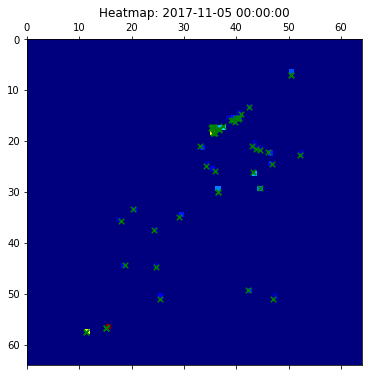

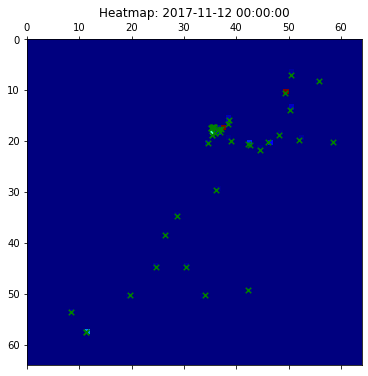

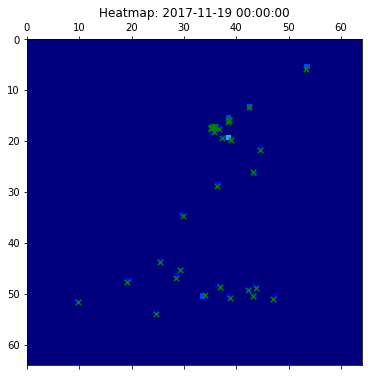

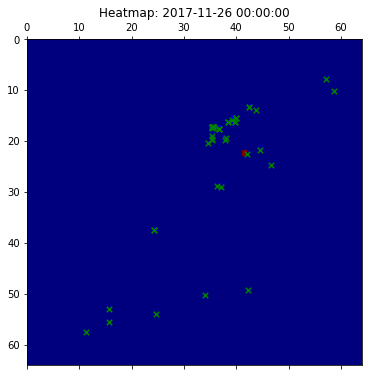

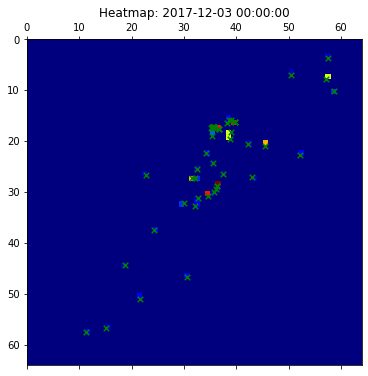

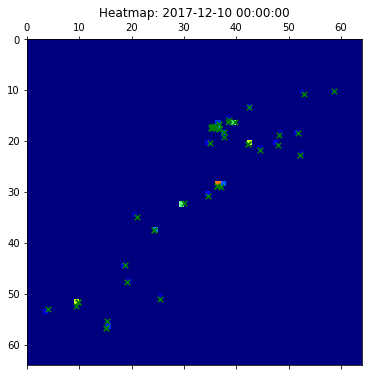

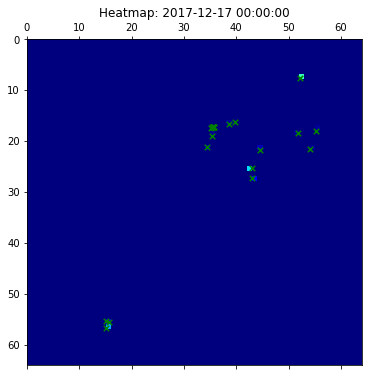

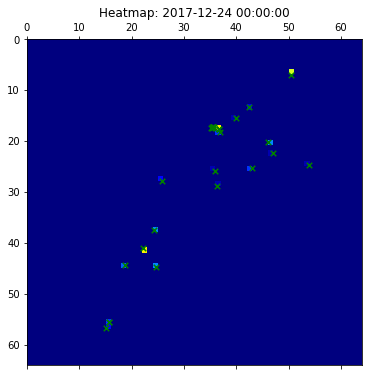

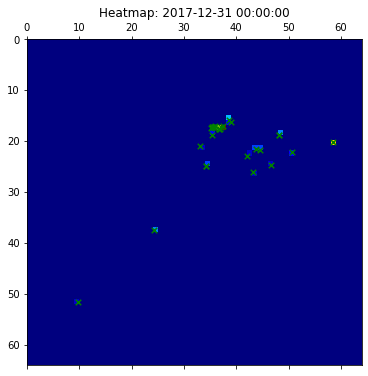

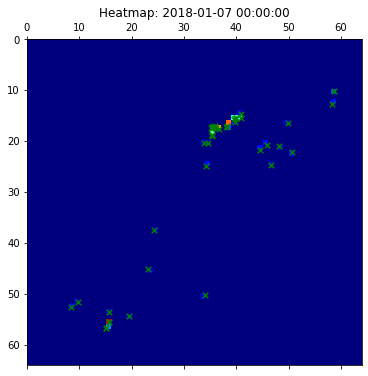

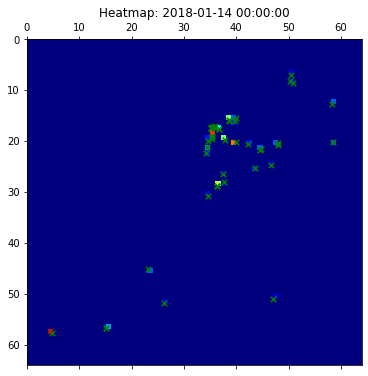

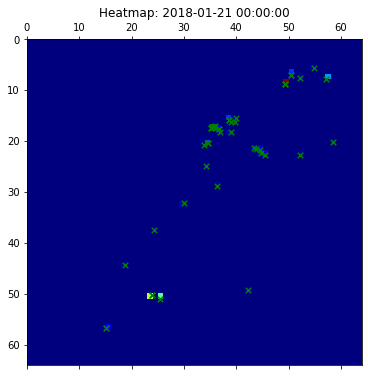

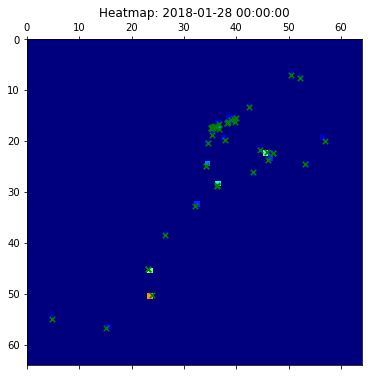

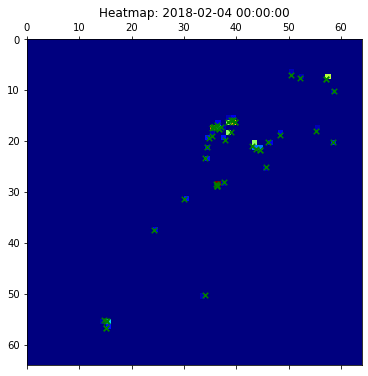

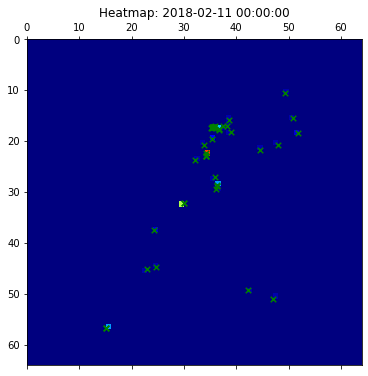

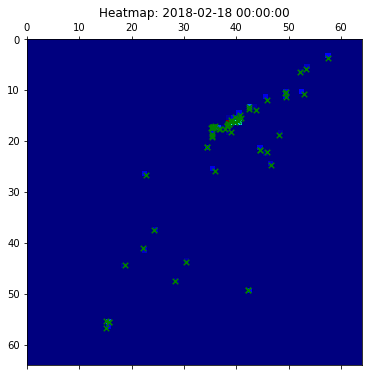

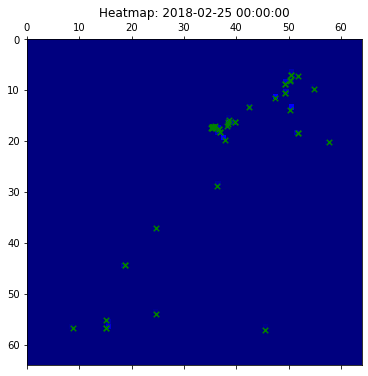

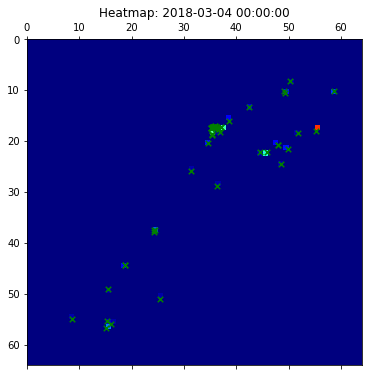

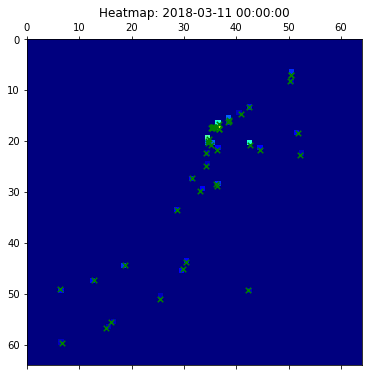

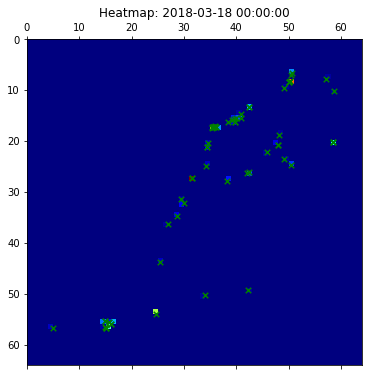

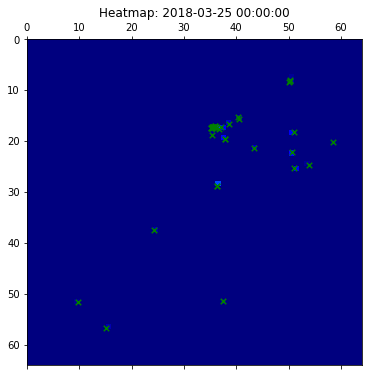

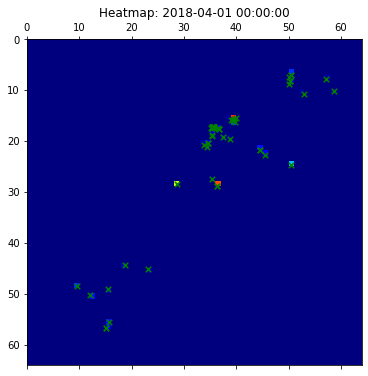

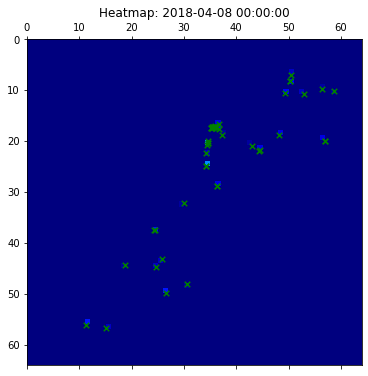

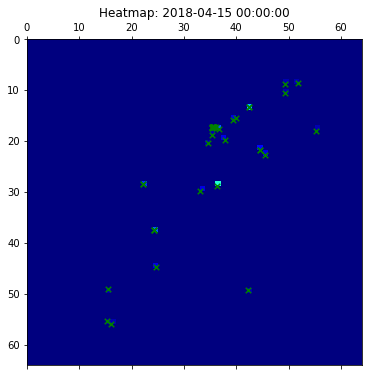

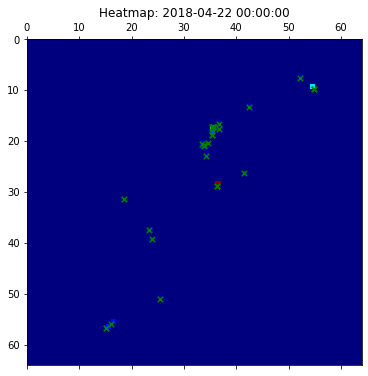

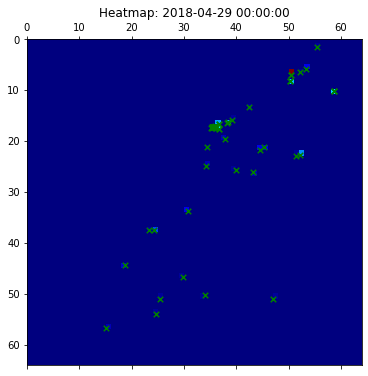

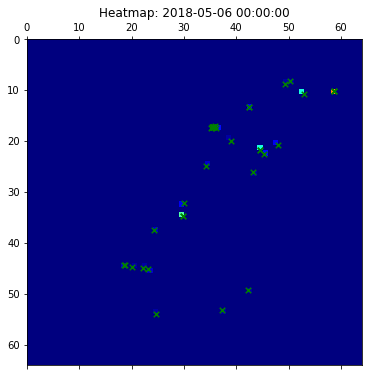

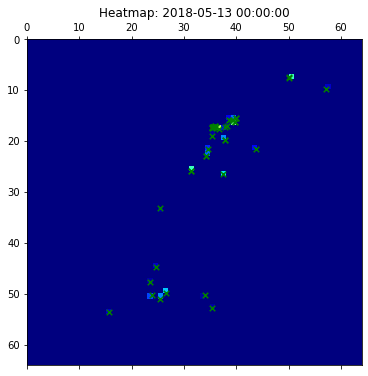

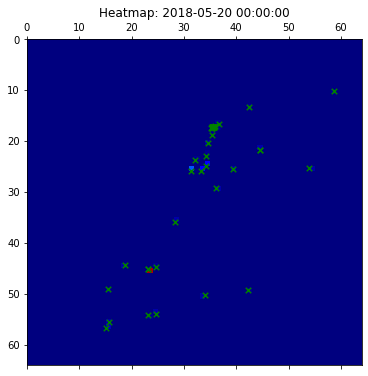

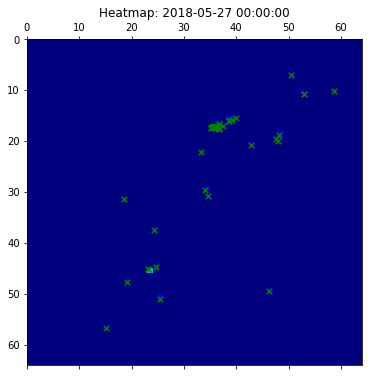

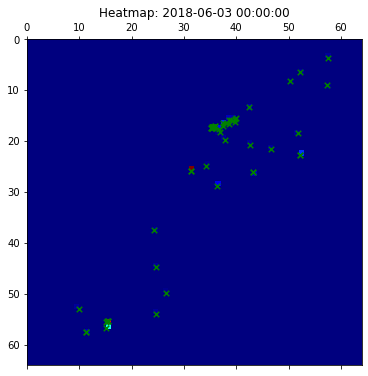

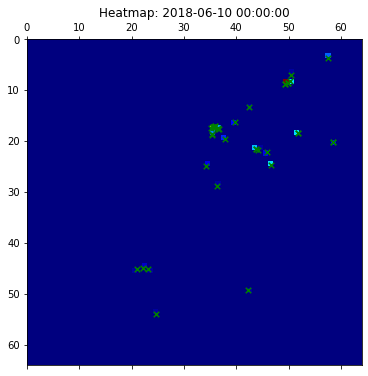

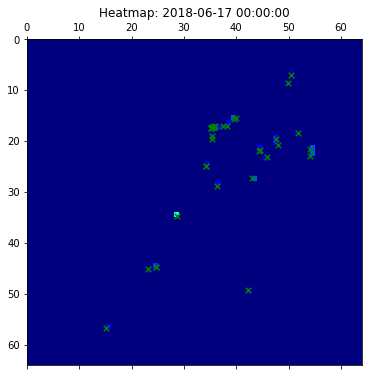

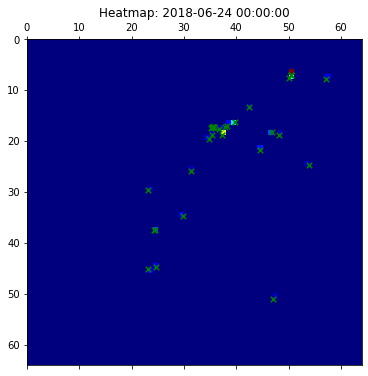

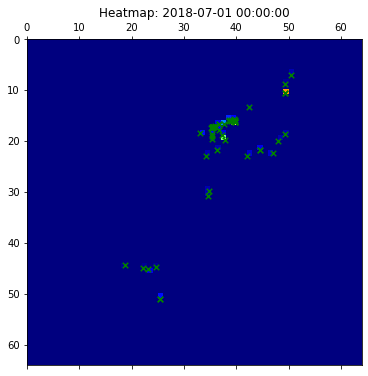

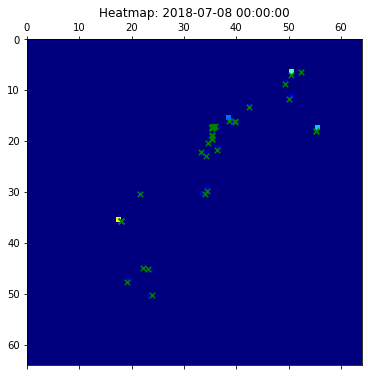

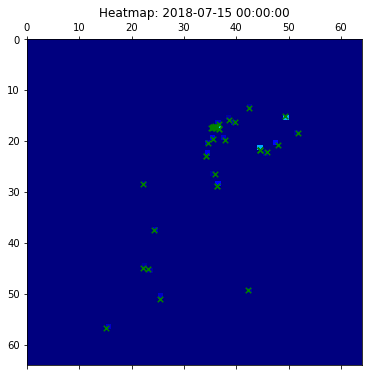

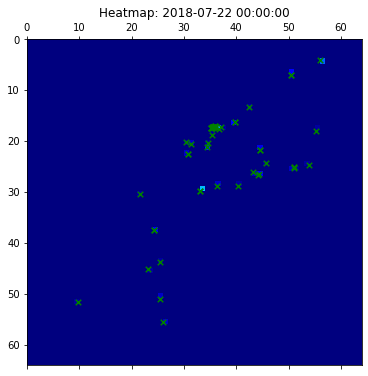

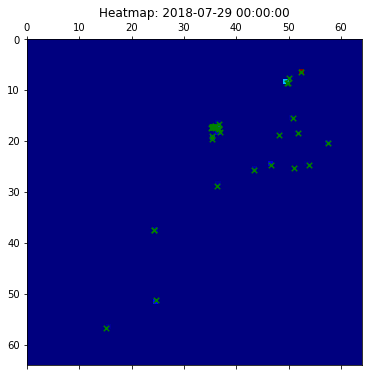

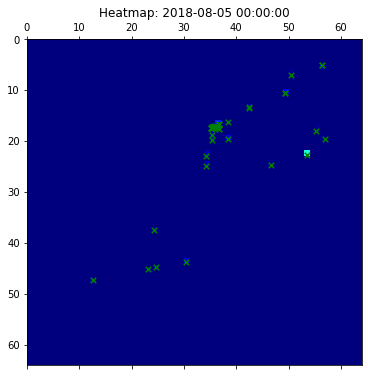

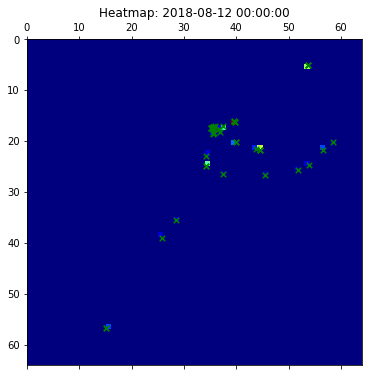

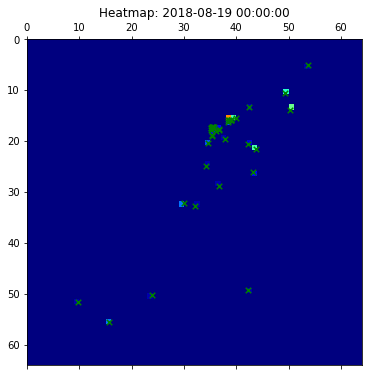

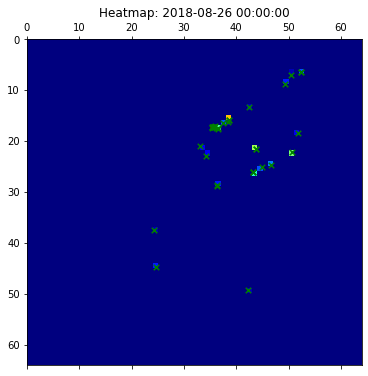

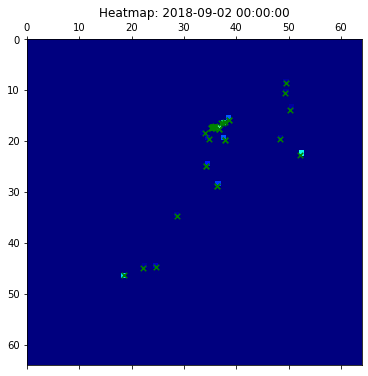

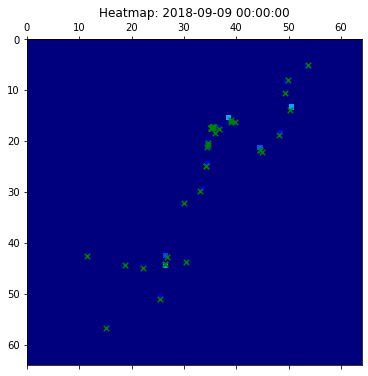

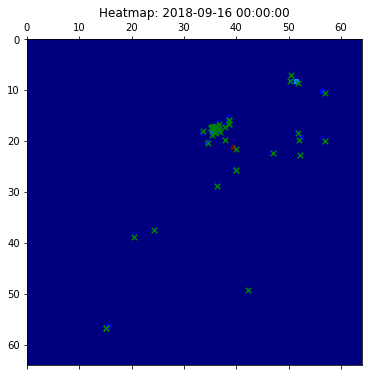

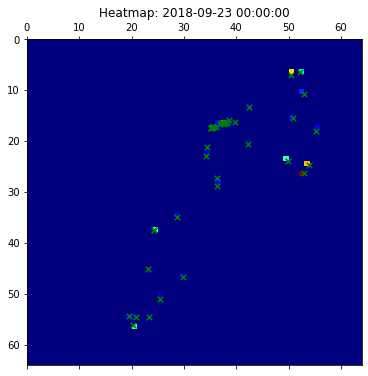

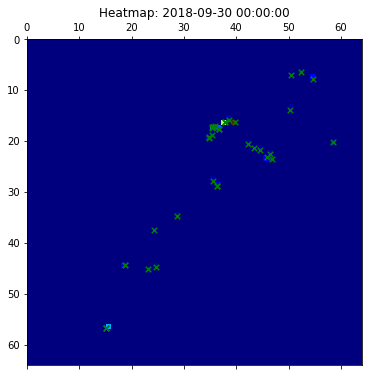

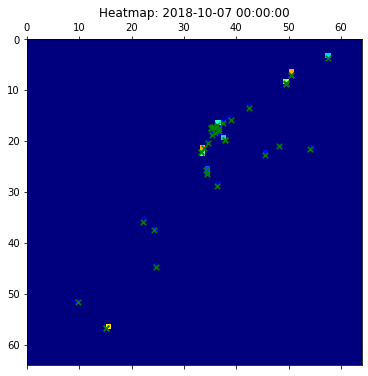

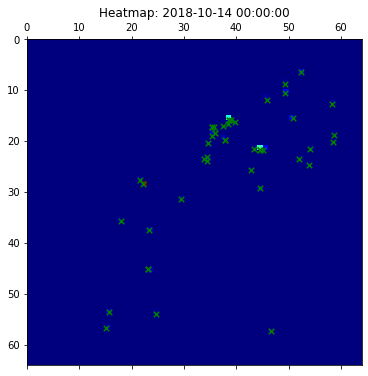

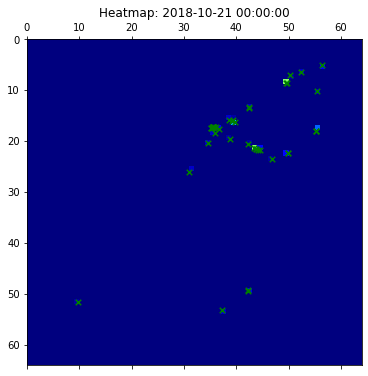

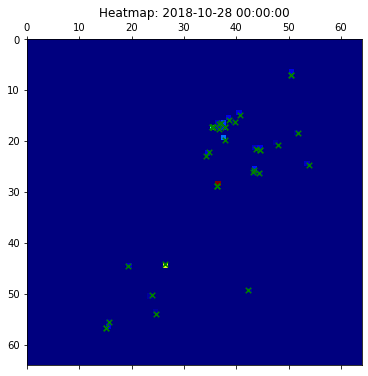

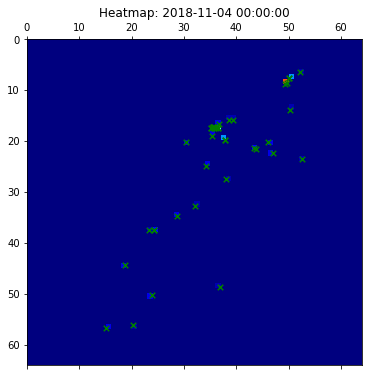

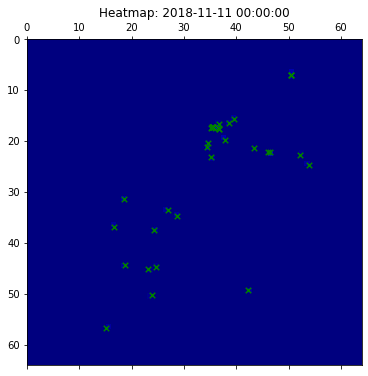

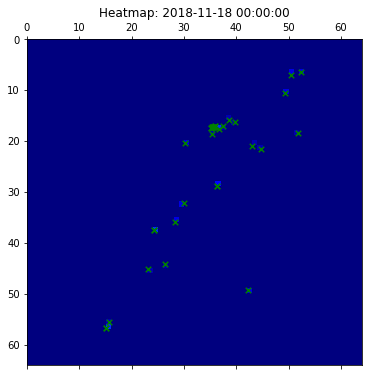

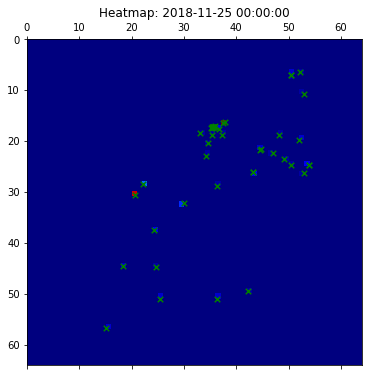

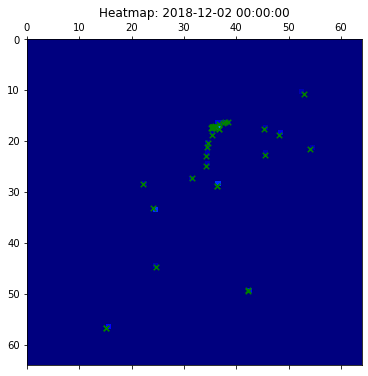

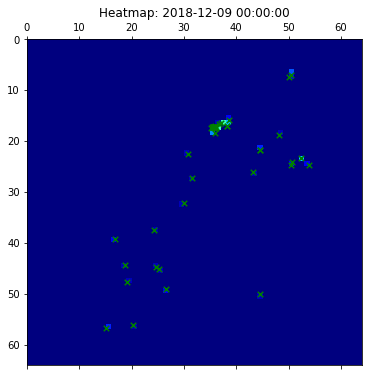

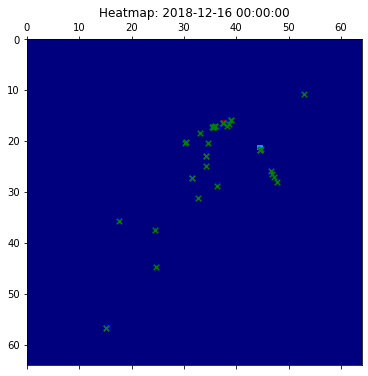

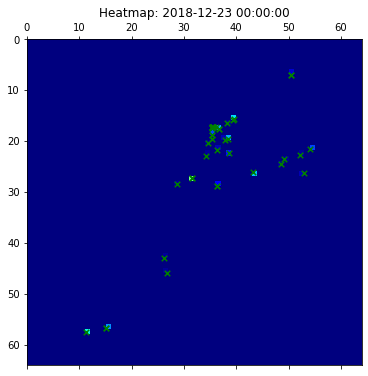

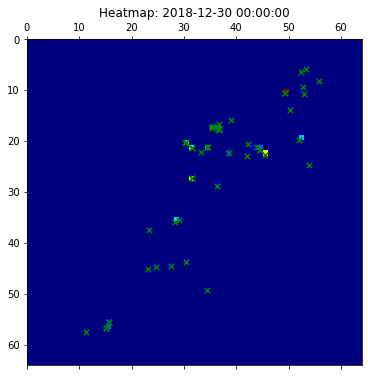

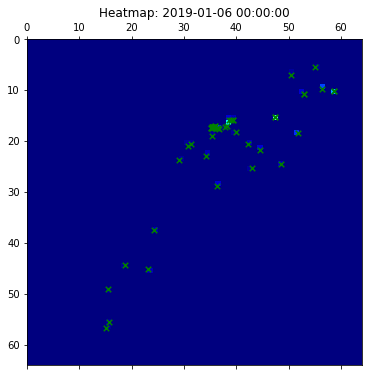

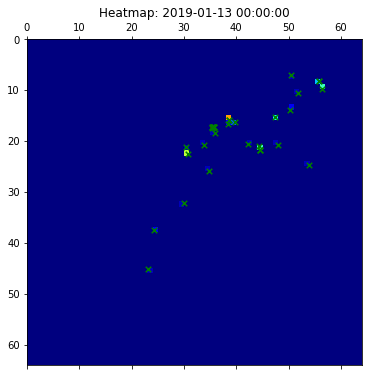

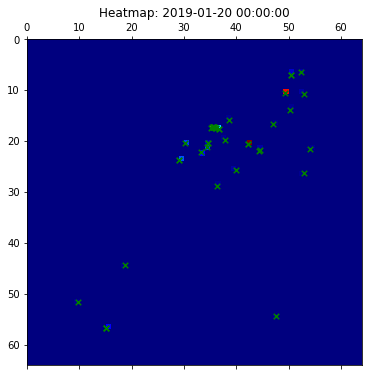

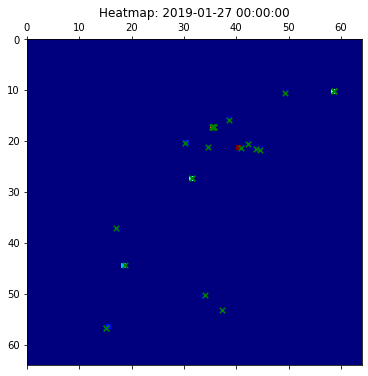

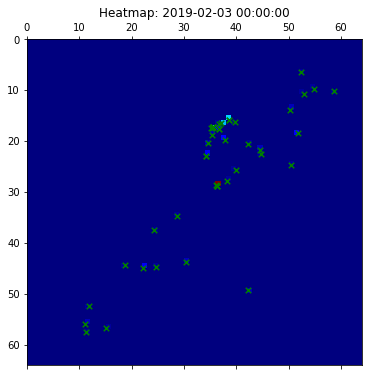

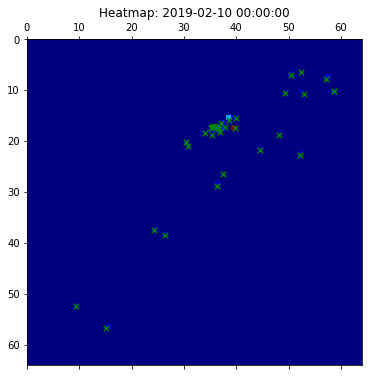

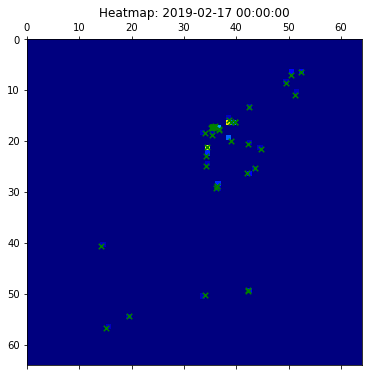

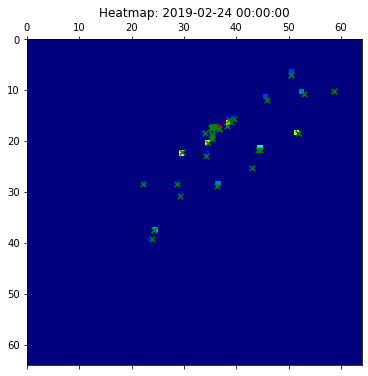

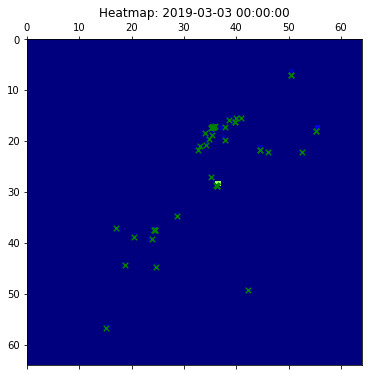

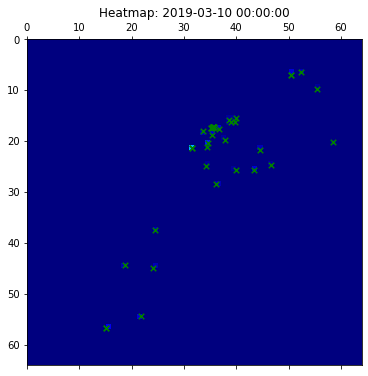

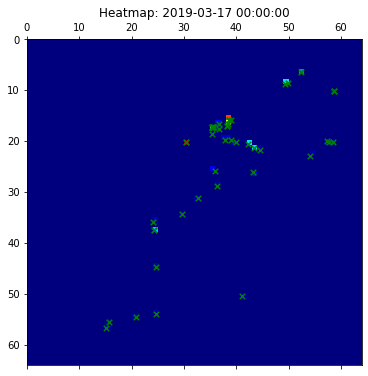

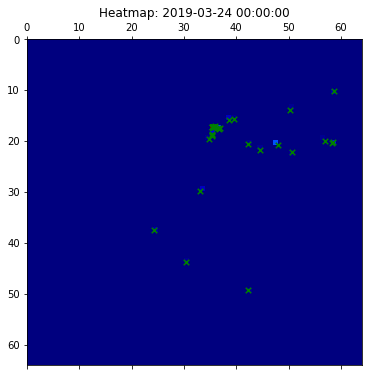

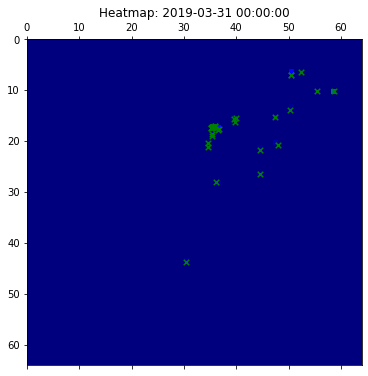

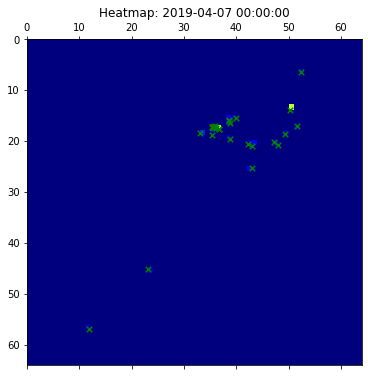

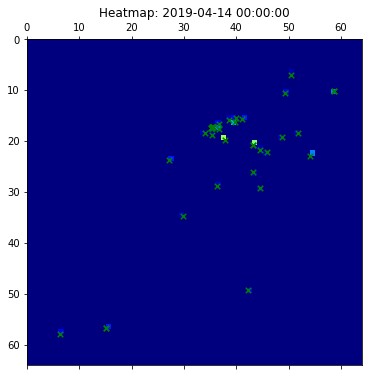

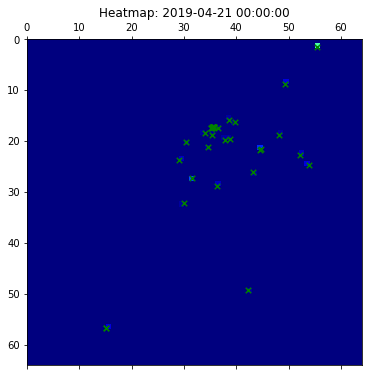

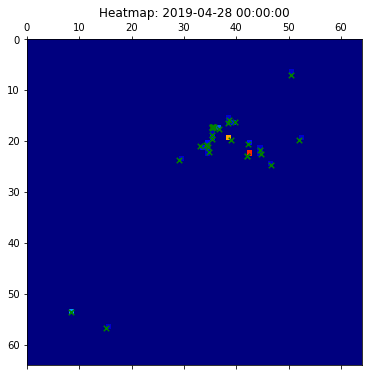

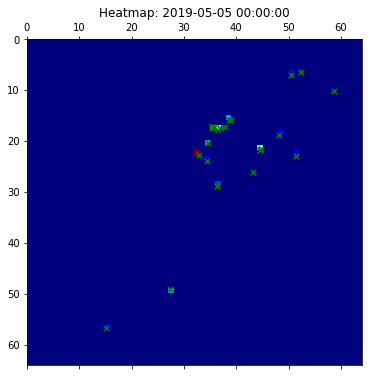

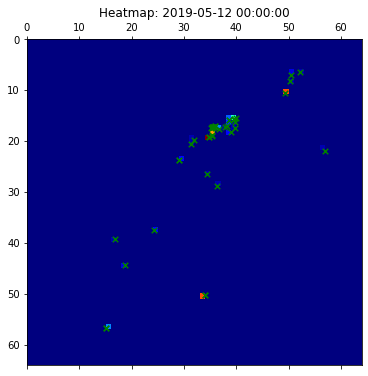

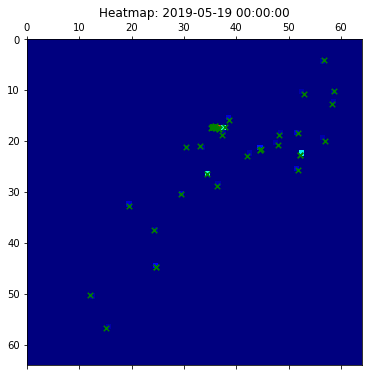

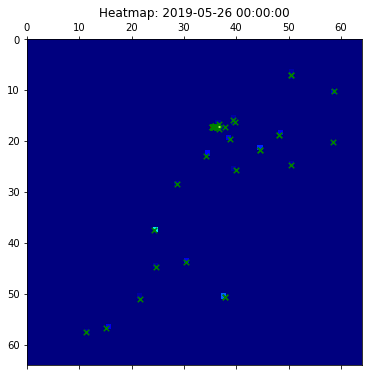

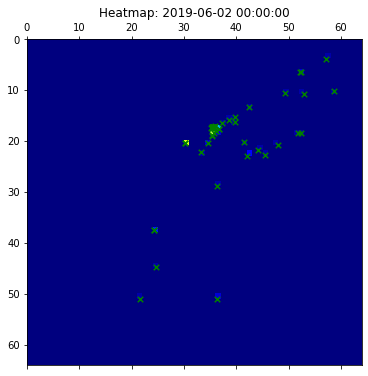

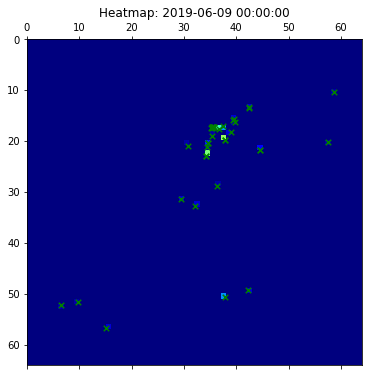

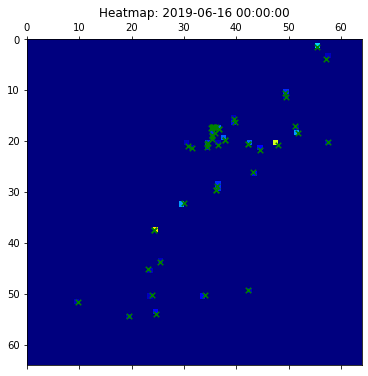

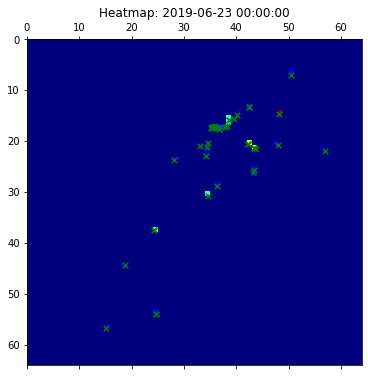

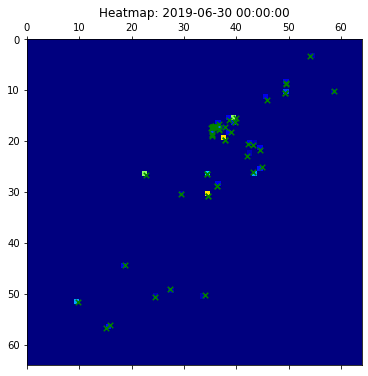

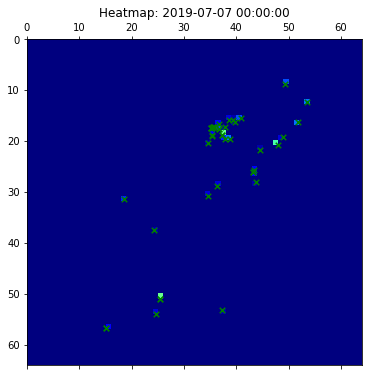

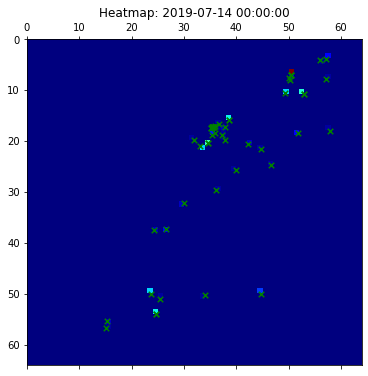

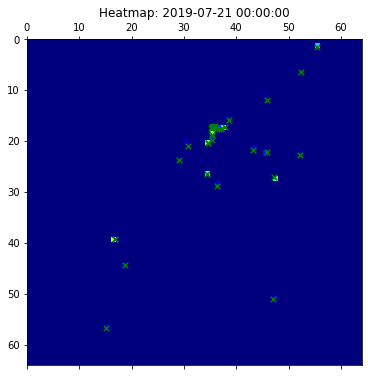

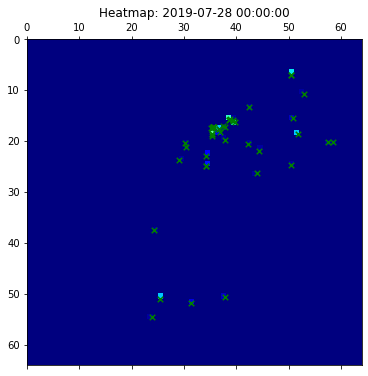

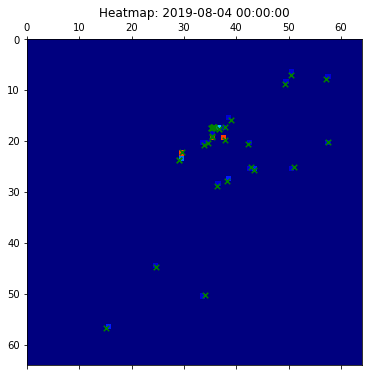

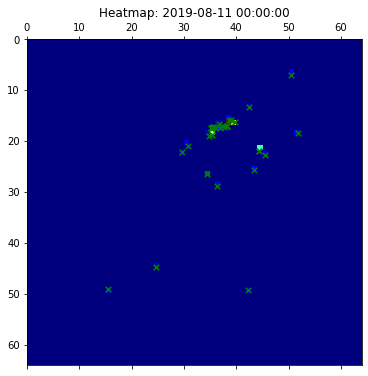

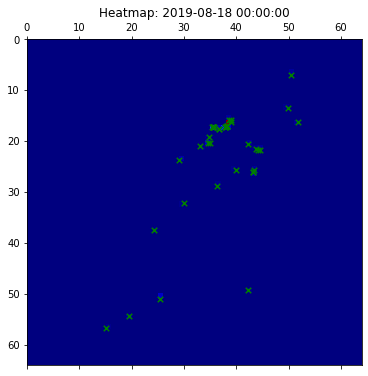

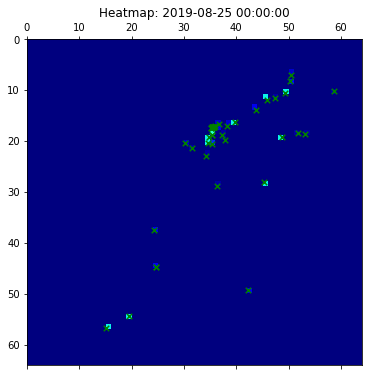

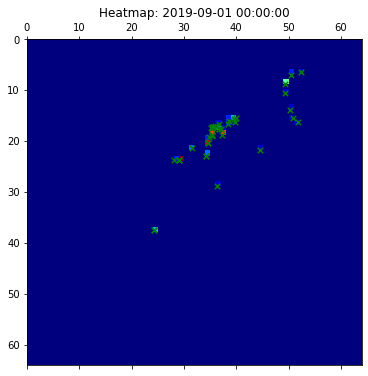

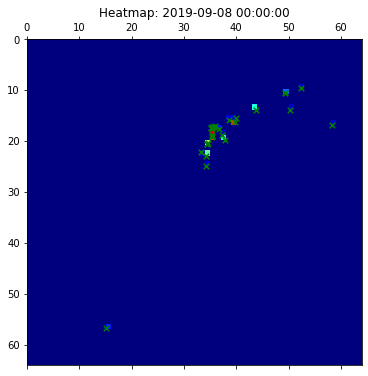

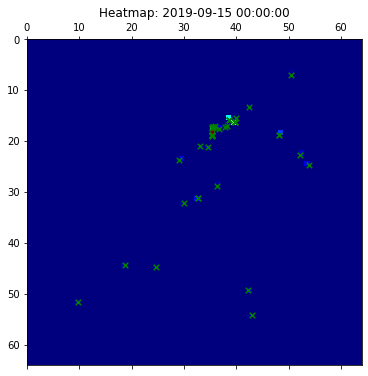

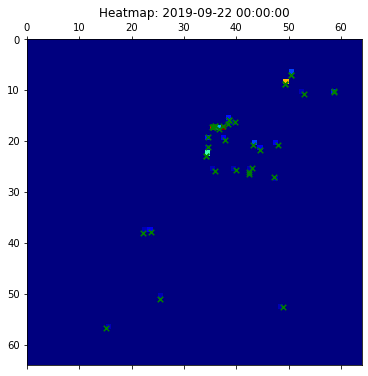

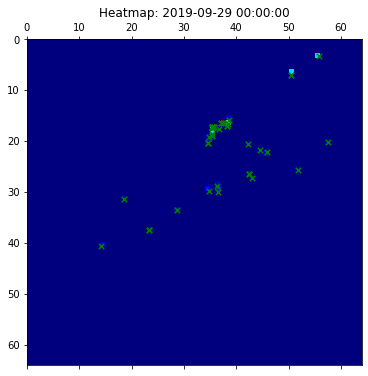

In [15]:
############################################################################################
# Plot some samples
############################################################################################

# last 100 weeks
n_samples = heat_df.shape[0]
heat_df = heat_df[-100:]

for i in range(100):

    # randomly select a sample
#     date = list(data.keys())[i]
    date = heat_df.index[i]
    datestring = str(date).split(' ')[0]
    
    # Get heatmap aggregation and incident coordinates
    coords = heat_df.loc[date,'coords']
    heatmap = heat_df.loc[date,'heatmap']
    
    # define the size of images
    f, ax = plt.subplots()
    f.set_figwidth(6)
    f.set_figheight(6)
    
    ax.set_title("Heatmap: {0}".format(date))
    imtitle = "Heatmap-{}".format(datestring) + '.png'
    
    ax.scatter(x=coords[:,1],y=coords[:,0], marker='x', s=30, color='green') 
    ax.matshow(heatmap, cmap='jet',aspect = ax.get_aspect(), extent = (0,map_height) + (map_width,0))
    
    dpath = {}
    dpath['home'] = './data/conflicts'
    dpath['subfolder'] = 'images/weekly'
    dpath['filename'] = imtitle

    f.savefig(os.path.join(dpath['home'],dpath['subfolder'],dpath['filename']))